In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from processing.TrackModeler import TrackModeler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import json
import os
from glob import glob
from collections import OrderedDict
from matplotlib.collections import PolyCollection
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from netCDF4 import Dataset
import cPickle
from scipy.ndimage import convolve, gaussian_filter
import matplotlib as mpl
from scipy.stats import spearmanr, multivariate_normal

In [39]:
def load_tracks(run_date):
    ensemble_members = ['cn'] + ['m%d' % m for m in range(3,14)]
    track_data = OrderedDict()
    for member in ensemble_members:
        track_path = "/sharp/djgagne/track_forecasts_spring2015_json/{0}/wrf-s3{1}_arw/".format(run_date, member)
        track_files = sorted(glob(track_path + "*.json"))
        track_data[member] = OrderedDict()
        print member
        for track_file in track_files:
            tfo = open(track_file)
            track_id = track_file[:-5].split("_")[-1]
            track_data[member][track_id] = json.load(tfo)
            tfo.close()
    return track_data

track_data = load_tracks(run_date)


NameError: name 'run_date' is not defined

In [481]:
durations = {}
for member in track_data.iterkeys():
    durations[member] = np.zeros(len(track_data[member]), dtype=int)
    for t, track in enumerate(track_data[member].keys()):
        durations[member][t] = track_data[member][track]['properties']['duration']

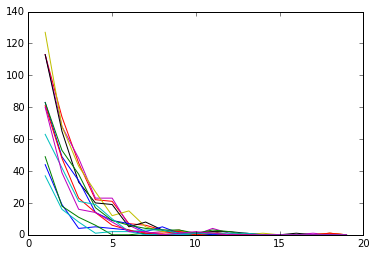

In [482]:
bins = np.arange(1, 21)
for member in durations.keys():
    hist_vals, bin_edges = np.histogram(durations[member], bins)
    plt.plot(bins[:-1], hist_vals)

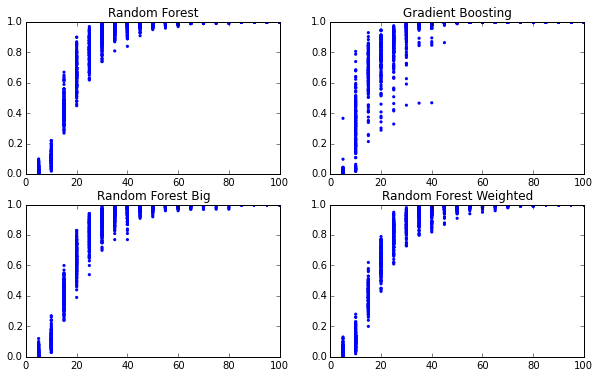

In [501]:
sizes = np.arange(5,105,5)
plt.figure(figsize=(10,6))
for m, model in enumerate(['Random-Forest', 'Gradient-Boosting', 'Random-Forest-Big','Random-Forest-Weighted']):
    plt.subplot(2,2,m+1)
    for t,track in enumerate(track_data['cn'].keys()):
        features = track_data['cn'][track]['features']
        for f in features:
            plt.scatter(sizes,np.cumsum(f['properties']['size_' + model]),10,'b',edgecolors='')
    plt.xlim(0,100)
    plt.ylim(0,1)
    plt.title(model.replace('-'," "))

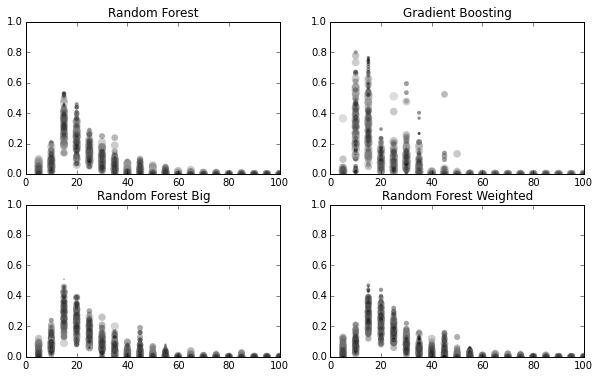

In [515]:
sizes = np.arange(5,105,5)
plt.figure(figsize=(10,6))
for m, model in enumerate(['Random-Forest', 'Gradient-Boosting', 'Random-Forest-Big','Random-Forest-Weighted']):
    plt.subplot(2,2,m+1)
    for t,track in enumerate(track_data['cn'].keys()):
        features = track_data['cn'][track]['features']
        for f in features:
            plt.scatter(sizes,
                        f['properties']['size_' + model],
                        100 * f['properties']['condition_' + model],
                        str(f['properties']['condition_' + model]),
                        edgecolors='',
                        vmin=0,vmax=1,alpha=0.5)
    plt.xlim(0,100)
    plt.ylim(0,1)
    plt.title(model.replace('-'," "))

In [392]:
hail_reports = pd.read_csv("http://www.spc.noaa.gov/climo/reports/yesterday_hail.csv")

In [2]:
hail_reports = pd.read_csv("http://www.spc.noaa.gov/climo/reports/150604_rpts_hail.csv")

In [104]:
hail_reports = pd.read_csv("http://www.spc.noaa.gov/climo/reports/today_hail.csv")

In [3]:
bmap = Basemap(projection='cyl', resolution='l',llcrnrlon=-126,llcrnrlat=24, urcrnrlon=-66,urcrnrlat=50)


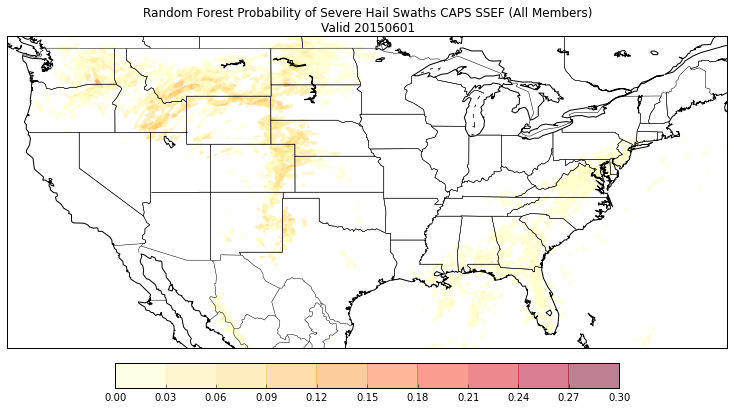

In [204]:
ensemble_members = ['cn'] + ['m%d' % m for m in range(3,14)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
for member in ensemble_members:
    for track in track_data[member].keys():
        coords = []
        hail_prob = []
        hail_size = []
        for t in range(len(track_data[member][track]['features'])):
            coords.append(np.array(track_data[member][track]['features'][t]['geometry']['coordinates']))
            hail_prob.append(track_data[member][track]['features'][t]['properties']['condition_Random-Forest'])
            hail_size.append(get_hail_size_prob(track_data[member][track]['features'][t]['properties']['size_Random-Forest'],25))
        hail_prob = np.array(hail_prob)
        hail_size = np.array(hail_size)
        col = PolyCollection(coords,array=hail_prob * hail_size,cmap=plt.get_cmap('YlOrRd',10),edgecolors='',alpha=0.5)
        col.set_clim(0,0.3)
        ax.add_collection(col)
#plt.scatter(hail_reports['Lon'], hail_reports['Lat'],20,'g', edgecolors='')
plt.colorbar(col, orientation='horizontal', fraction=0.05,shrink=0.7, pad=0.02)
plt.title("Random Forest Probability of Severe Hail Swaths CAPS SSEF (All Members)\nValid {0}".format(run_date))
plt.savefig("/sharp/djgagne/hail_figures_spring2015/ssef_hail_swaths_{0}.png".format(run_date), dpi=200, bbox_edges='tight')

In [4]:
def get_hail_size_percentile(size_pdf, percentile, size_bins=np.arange(5,105,5)):
    size_cdf = np.cumsum(size_pdf)
    return size_bins[np.argmin(np.abs(size_cdf - percentile))]

def get_hail_size_prob(size_pdf, size_thresh, size_bins=np.arange(5,105,5)):
    size_cdf = 1 - np.cumsum(size_pdf)
    return size_cdf[np.argmin(np.abs(size_bins - size_thresh))]

In [5]:
ssef_grid = {}
ssef_grid_obj = Dataset("/sharp/djgagne/ssef_2015_grid.nc")
for variable in ssef_grid_obj.variables.iterkeys():
    ssef_grid[variable] = np.array(ssef_grid_obj.variables[variable][:])
ssef_grid_obj.close()

In [44]:
time_errors = np.arange(-6,7)
time_mem = "m10"
track_time_pdfs = np.zeros((len(track_data[time_mem]), time_errors.size))
for t, track in enumerate(track_data[time_mem].keys()):
    track_time_pdfs[t] = np.array(track_data[time_mem][track]['features'][0]['properties']['start-time_Random-Forest'])

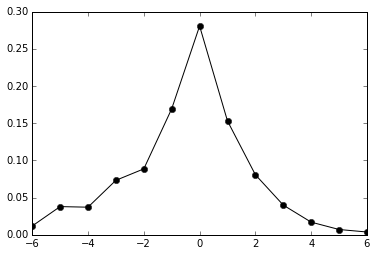

In [45]:
plt.plot(time_errors, track_time_pdfs.mean(axis=0), 'ko-')

In [6]:
ens_members = ['wrf-s3cn_arw'] + ['wrf-s3m%d_arw' % m for m in range(3,14)]
model_abb = {"Random-Forest":'rf',"Gradient-Boosting":'gb',"Random-Forest-Big":'rfb', "Random-Forest-Weighted":'rfw'}
#ens_members = ['wrf-s3cn_arw'] + ['wrf-s3m%d_arw' % m for m in [3,4,5,6,7,9,11,12,13]]
ens_mean = None
sample_path = "/sharp/djgagne/track_samples_spring2015/"
out_path = "/sharp/djgagne/track_sample_figures_spring2015/"
run_date = "20150604"
model = "Gradient-Boosting"
thresh = 25
data = {}
for member in ens_members:
    print member
    model_file = sorted(glob(sample_path + run_date + "/" + model + "_*" + member + "*.nc"))
    model_obj = Dataset(model_file[0])
    data[member] = model_obj.variables["prob_hail_{0:02d}_mm".format(thresh)][:]
    model_obj.close()

wrf-s3cn_arw
wrf-s3m3_arw
wrf-s3m4_arw
wrf-s3m5_arw
wrf-s3m6_arw
wrf-s3m7_arw
wrf-s3m8_arw
wrf-s3m9_arw
wrf-s3m10_arw
wrf-s3m11_arw
wrf-s3m12_arw
wrf-s3m13_arw


In [448]:
if not os.access(out_path + run_date, os.R_OK):
    os.mkdir(out_path + run_date)

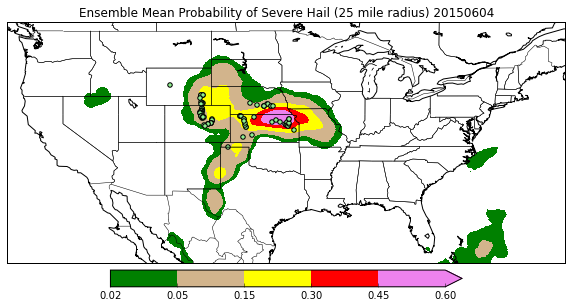

In [7]:
mean_map = np.zeros(ssef_grid['lon'].shape)
for mem in data.keys():
    mean_map += data[mem].sum(axis=0)
mean_map /= len(data)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             mean_map, 
             np.array([0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Ensemble Mean Probability of Severe Hail (25 mile radius) " + run_date)
plt.scatter(hail_reports['Lon'], hail_reports['Lat'],20,'lightgreen')
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_outlook_{0}_{1}.png".format(run_date,model_abb[model]), dpi=150, bbox_inches="tight")


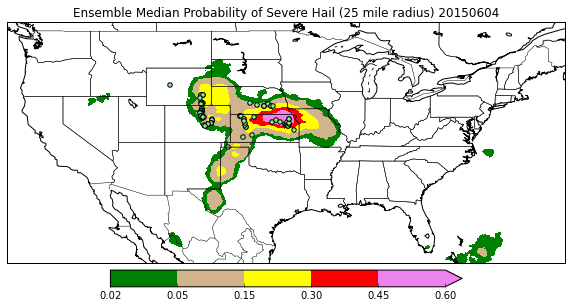

In [10]:
med_map = np.zeros((len(data),ssef_grid['lon'].shape[0],ssef_grid['lon'].shape[1]))
for m,mem in enumerate(data.keys()):
    med_map[m] = data[mem].sum(axis=0)
median_map = np.percentile(med_map, 50, axis=0)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             median_map, 
             np.array([0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Ensemble Median Probability of Severe Hail (25 mile radius) " + run_date)
plt.scatter(hail_reports['Lon'], hail_reports['Lat'],20,'lightgreen')
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_median_outlook_{0}_{1}.png".format(run_date,
                                                                                                       model_abb[model]), 
            dpi=150, bbox_inches="tight")


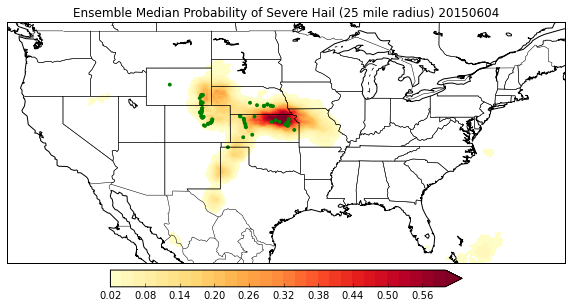

In [11]:
med_map = np.zeros((len(data),ssef_grid['lon'].shape[0],ssef_grid['lon'].shape[1]))
for m,mem in enumerate(data.keys()):
    med_map[m] = data[mem].sum(axis=0)
median_map = np.percentile(med_map, 50, axis=0)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             median_map, 
             np.arange(0.02,0.62,0.02), 
             cmap='YlOrRd', extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Ensemble Median Probability of Severe Hail (25 mile radius) " + run_date)
plt.scatter(hail_reports['Lon'], hail_reports['Lat'],15,'green',edgecolors='')
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_red_median_outlook_{0}_{1}.png".format(run_date,
                                                                                                           model_abb[model]),
            dpi=150, bbox_inches="tight")


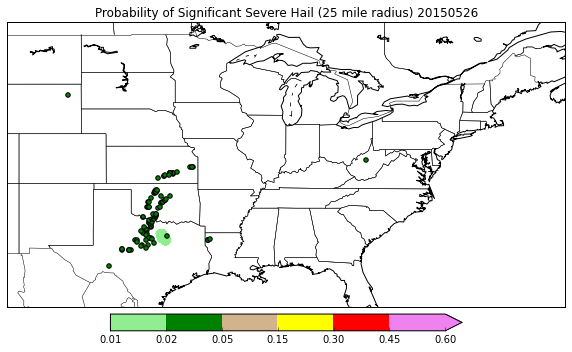

In [83]:
mean_map = np.zeros(ssef_grid['lon'].shape)
for mem in data.keys():
    mean_map += data[mem].sum(axis=0)
mean_map /= len(data)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             gaussian_filter(mean_map,5), 
             np.array([0.01, 0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["lightgreen","green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Probability of Significant Severe Hail (25 mile radius) " + run_date)
plt.scatter(hail_reports['Lon'], hail_reports['Lat'],20,'g')
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_outlook_{0}_sig_{1}.png".format(run_date,model_abb[model]), dpi=150, bbox_inches="tight")


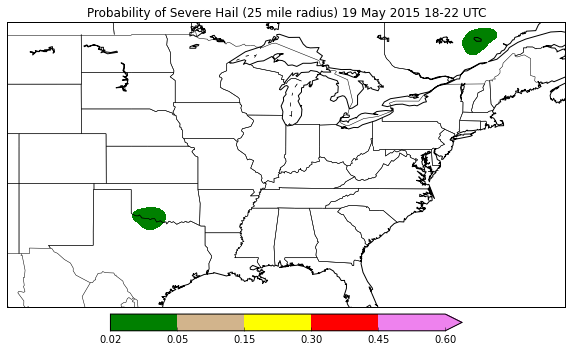

In [185]:
mean_map = np.zeros(ssef_grid['lon'].shape)
for mem in data.keys():
    mean_map += data[mem][6:10].sum(axis=0)
mean_map /= len(data)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             gaussian_filter(mean_map,10), 
             np.array([0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Probability of Severe Hail (25 mile radius) 19 May 2015 18-22 UTC")

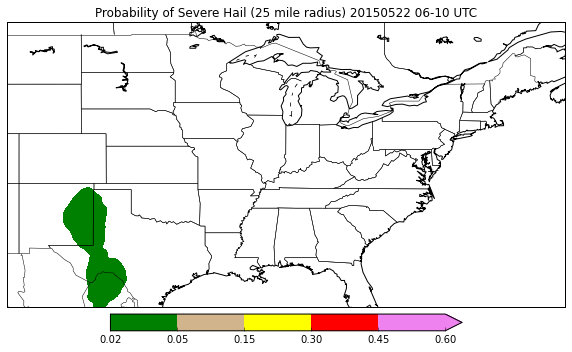

In [322]:
mean_map = np.zeros(ssef_grid['lon'].shape)
st = 18
et = 22
for mem in data.keys():
    mean_map += data[mem][st:et].sum(axis=0)
mean_map /= len(data)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             gaussian_filter(mean_map,5), 
             np.array([0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Probability of Severe Hail (25 mile radius) {2} {0:02d}-{1:02d} UTC".format((12 + st) % 24,
                                                                                       (12 + et) % 24,
                                                                                       run_date))
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_mean_outlook_{0}_{1:02d}_{2:02d}.png".format(run_date,
                                                                                                             12+st,
                                                                                                             12+et), 
            dpi=150, bbox_inches="tight")


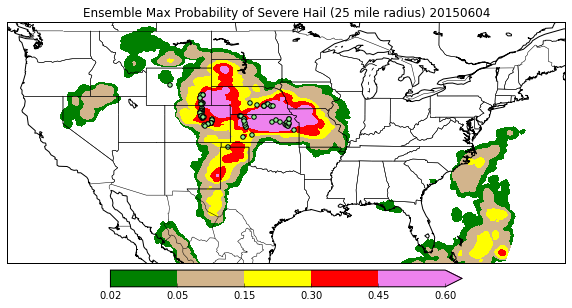

In [12]:
max_map = np.zeros(ssef_grid['lon'].shape)
for mem in data.keys():
    max_map = np.maximum(data[mem].sum(axis=0), max_map)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             gaussian_filter(max_map,2), 
             np.array([0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Ensemble Max Probability of Severe Hail (25 mile radius) " + run_date)
plt.scatter(hail_reports['Lon'], hail_reports['Lat'],20,'lightgreen')
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_max_outlook_{0}_{1}.png".format(run_date,
                                                                                                    model_abb[model]), 
            dpi=150, bbox_inches="tight")


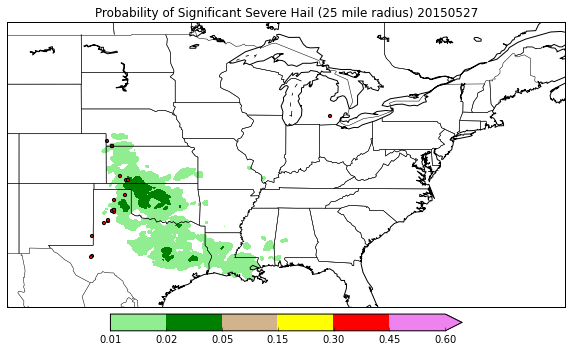

In [121]:
max_map = np.zeros(ssef_grid['lon'].shape)
for mem in data.keys():
    max_map = np.maximum(data[mem].sum(axis=0), max_map)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             gaussian_filter(max_map,2), 
             np.array([0.01, 0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["lightgreen", "green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Probability of Significant Severe Hail (25 mile radius) " + run_date)
#plt.scatter(hail_reports['Lon'], hail_reports['Lat'],10,'red')
plt.scatter(hail_reports['Lon'][hail_reports['Size'] >= 200], hail_reports['Lat'][hail_reports['Size'] >= 200],10,'red')

plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_max_outlook_{0}_sig_rf.png".format(run_date), dpi=150, bbox_inches="tight")


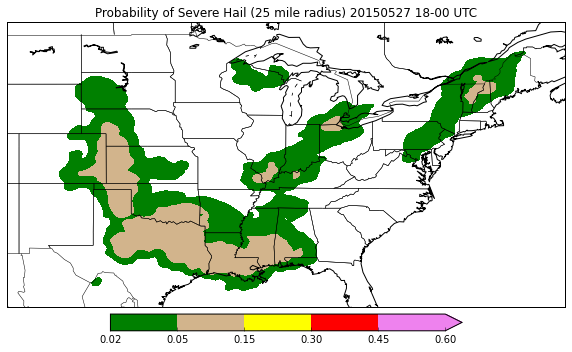

In [108]:
max_map = np.zeros(ssef_grid['lon'].shape)
st = 6
et = 12
for mem in data.keys():
    max_map = np.maximum(data[mem][st:et].sum(axis=0),max_map)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
             gaussian_filter(max_map,5), 
             np.array([0.02, 0.05,0.15,0.30,0.45,0.6]), 
             colors=["green", "tan", "yellow","red","violet"], extend="max")
plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.title("Probability of Severe Hail (25 mile radius) {0} {1:02d}-{2:02d} UTC".format(run_date,
                                                                                       (12 + st) % 24,
                                                                                       (12 + et) % 24))
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_max_{0}_{1:02d}_{2:02d}.png".format(run_date,12+st,12+et), dpi=150, bbox_inches="tight")


In [403]:
for st in range(3,22):
    print st
    max_map = np.zeros(ssef_grid['lon'].shape)
    et = st + 3
    for mem in data.keys():
        max_map = np.maximum(data[mem][st:et].sum(axis=0),max_map)
    plt.figure(figsize=(10,6))
    bmap.drawstates()
    bmap.drawcoastlines()
    bmap.drawcountries()
    plt.contourf(ssef_grid['lon'], ssef_grid['lat'], 
                 gaussian_filter(max_map,1), 
                 np.arange(0.02,0.20,.01), 
                 cmap="YlOrRd", extend="max")
    plt.colorbar(orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
    plt.title("Ensemble Maximum Probability of Severe Hail (25 mile radius) {2} {0:02d}-{1:02d} UTC".format((12 + st) % 24,
                                                                                           (12 + et) % 24,
                                                                                           run_date))
    plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_max_red_{0}_{1:02d}_hour_{2:02d}.png".format(run_date,et-st,12+st), 
                dpi=150, bbox_inches="tight")
    plt.close()

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [133]:
for mem in data.keys():
    print mem, data[mem].max()

wrf-s3m8_arw 0.064
wrf-s3cn_arw 0.068
wrf-s3m5_arw 0.079
wrf-s3m6_arw 0.052
wrf-s3m10_arw 0.07
wrf-s3m13_arw 0.068
wrf-s3m11_arw 0.051
wrf-s3m12_arw 0.072
wrf-s3m3_arw 0.047
wrf-s3m4_arw 0.064
wrf-s3m9_arw 0.053
wrf-s3m7_arw 0.043


In [46]:
import Nio

In [60]:
rqi = Nio.open_file("/sharp/djgagne/mrms/20150526/RadarQualityIndex_00.00/MRMS_RadarQualityIndex_00.00_20150526-120000.grib2")
print rqi.variables.keys()
rqi_data = rqi.variables.values()[0][:]
lon_r = rqi.variables['lon_0'][:]
lat_r = rqi.variables['lat_0'][:]
rqi.close()

['VAR_209_8_0_P0_L102_GLL0', 'lon_0', 'lat_0']


(7000,) (3500,) (3500, 7000)


<matplotlib.colorbar.Colorbar instance at 0x2b8ee7673680>

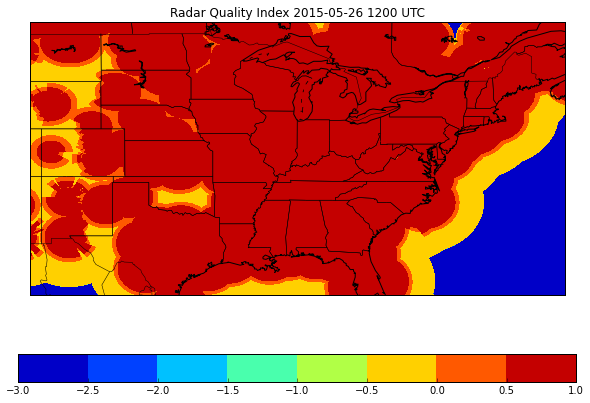

In [67]:
print lon_r.shape, lat_r.shape, rqi_data.shape
plt.figure(figsize=(10,7))
bmap.drawstates()
bmap.drawcountries()
bmap.drawcoastlines()
plt.title("Radar Quality Index 2015-05-26 1200 UTC")
plt.contourf(lon_r-360, lat_r, rqi_data)
plt.colorbar(orientation="horizontal")

In [65]:
print lon_r

[ 230.00500488  230.01499939  230.0249939  ...,  299.9750061   299.98498535
  299.99499512]


In [220]:
data_files = sorted(glob("/sharp/djgagne/track_data_spring2014_csv/track_total_ssef*.csv"))
track_data_list = []
for df in data_files:
    track_data_list.append(pd.read_csv(df))
track_data = pd.concat(track_data_list, ignore_index=True)
del track_data_list

In [240]:
track_data.dropna(inplace=True)

In [250]:
x_ranks = track_data['Start_Time_Error'].values.argsort()
y_ranks = track_data['End_Time_Error'].values.argsort()

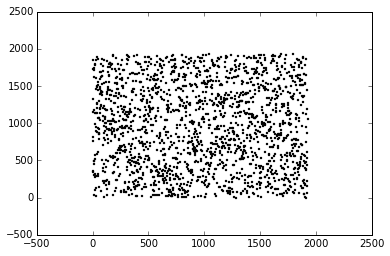

In [253]:
plt.scatter(x_ranks, y_ranks,2,'k')

In [270]:
error_cols = ['Start_Time_Error','Translation_Error_X', 'Translation_Error_Y']
error_cov = np.cov(track_data.loc[:, error_cols].values.T)
means = np.mean(track_data.loc[:, error_cols], axis=0)
np.random.multivariate_normal(means, error_cov,10)

array([[ -4.76870735e-01,  -9.05942808e+04,   5.05623411e+04],
       [  8.60658447e-01,   2.34098384e+05,  -7.21951833e+04],
       [ -4.21503772e-01,  -5.94757127e+04,   1.14832144e+05],
       [ -6.46677730e-01,   3.18589712e+04,  -8.43898453e+04],
       [ -3.08908239e-01,  -1.15062878e+03,   3.12989476e+04],
       [ -1.49519787e-01,  -7.87106419e+04,  -5.76016577e+04],
       [ -1.64828874e+00,  -2.37651442e+04,   3.21956416e+04],
       [ -3.31792408e+00,  -2.09790215e+05,  -1.21272537e+04],
       [ -4.22196000e-01,   2.70869463e+04,   1.12612077e+05],
       [  1.31034064e+00,   7.17278246e+04,  -2.00772798e+05]])

In [264]:
track_data.loc[:,['Start_Time_Error','Translation_Error_X', 'Translation_Error_Y']].mean(axis=0)

Start_Time_Error         -0.028542
Translation_Error_X    1373.295885
Translation_Error_Y    9300.287663
dtype: float64

In [292]:
hist_obs = np.array([[10.7,10.9,13.5],
                     [9.3,9.1,13.7],
                     [6.8,7.2,9.3],
                     [11.3,10.7,15.6],
                     [12.2,13.1,17.8],
                     [13.6,14.2,19.3],
                     [8.9,9.4,12.1],
                     [9.9,9.2,11.8],
                     [11.8,11.9,15.2],
                     [12.9,12.5,16.9]
                    ])
ens_output = np.array([[7.5,6.3,12.4],
                       [8.3,7.2,13.5],
                       [8.8,7.5,14.2],
                       [9.7,7.9,14.5],
                       [10.1,8.6,15.6],
                       [10.3,9.3,15.9],
                       [11.2,11.8,16.3],
                       [11.9,12.2,17.6],
                       [12.5,13.5,18.3],
                       [15.3,17.7,23.9],
                      ])
ranked_hist_obs = np.argsort(hist_obs,axis=0)
shuffled_ens = np.zeros(ens_output.shape)
for i in range(shuffled_ens.shape[1]):
    shuffled_ens[ranked_hist_obs[:,i],i] = ens_output[:,i]
print shuffled_ens

[[ 10.1   9.3  14.5]
 [  8.8   7.2  15.6]
 [  7.5   6.3  12.4]
 [ 10.3   8.6  16.3]
 [ 11.9  13.5  18.3]
 [ 15.3  17.7  23.9]
 [  8.3   7.9  14.2]
 [  9.7   7.5  13.5]
 [ 11.2  11.8  15.9]
 [ 12.5  12.2  17.6]]


0.361000001431


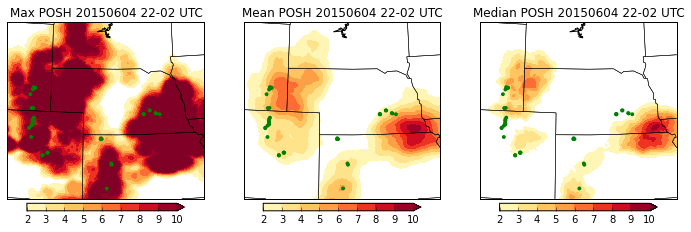

In [478]:
bmap2 = Basemap(projection='lcc', resolution='l', lon_0=-100.68,lat_0=41.13,width=1e6,height=9e5)
st = 11
et = 15
mean_map = np.zeros(ssef_grid['lon'].shape)
for mem in data.keys():
    mean_map += data[mem][st:et].sum(axis=0)
mean_map = mean_map / float(len(data.keys()))
max_map = np.zeros(ssef_grid['lon'].shape)
for mem in data.keys():
    max_map = np.maximum(data[mem][st:et].sum(axis=0), max_map)
print max_map.max()
med_map = np.zeros((len(data),ssef_grid['lon'].shape[0],ssef_grid['lon'].shape[1]))
for m,mem in enumerate(data.keys()):
    med_map[m] = data[mem][st:et].sum(axis=0)
median_map = np.percentile(med_map, 50, axis=0)
plt.figure(figsize=(12,4))
for p in range(3):
    plt.subplot(1,3,p+1)
    bmap2.drawstates()
    bmap2.drawcoastlines()
    bmap2.drawcountries()
    x, y = bmap2(ssef_grid['lon'], ssef_grid['lat'])
    hr_idxs = (hail_reports['Time'] >= 2200) | (hail_reports['Time'] <= 200)
    rx, ry = bmap2(hail_reports['Lon'][hr_idxs].values, hail_reports['Lat'][hr_idxs].values)
    if p == 0:
        cont = plt.contourf(x,y, 
                 gaussian_filter(max_map,1) * 100, 
                 np.arange(2,11,1),
                 cmap="YlOrRd", extend="max")
        plt.title("Max POSH {0} {1:02d}-{2:02d} UTC".format(run_date,
                                                                                           (11 + st) % 24,
                                                                                           (11 + et) % 24))
    elif p == 1:
        cont = plt.contourf(x,y, 
                 gaussian_filter(mean_map,1) * 100, 
                 np.arange(2, 11, 1),
                 cmap="YlOrRd", extend="max")
        plt.title("Mean POSH {0} {1:02d}-{2:02d} UTC".format(run_date,
                                                                                           (11 + st) % 24,
                                                                                           (11 + et) % 24))
    elif p == 2:
        cont = plt.contourf(x,y, 
                 gaussian_filter(median_map,1) * 100, 
                 np.arange(2, 11, 1),
                 cmap="YlOrRd", extend="max")
        plt.title("Median POSH {0} {1:02d}-{2:02d} UTC".format(run_date,
                                                                                           (11 + st) % 24,
                                                                                           (11 + et) % 24))
    plt.scatter(rx,ry,15,'green', edgecolors='')
    plt.colorbar(cont, orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_mean_max_comp_{0}_{1:02d}_{2:02d}.png".format(run_date,12+st,12+et), dpi=150, bbox_inches="tight")

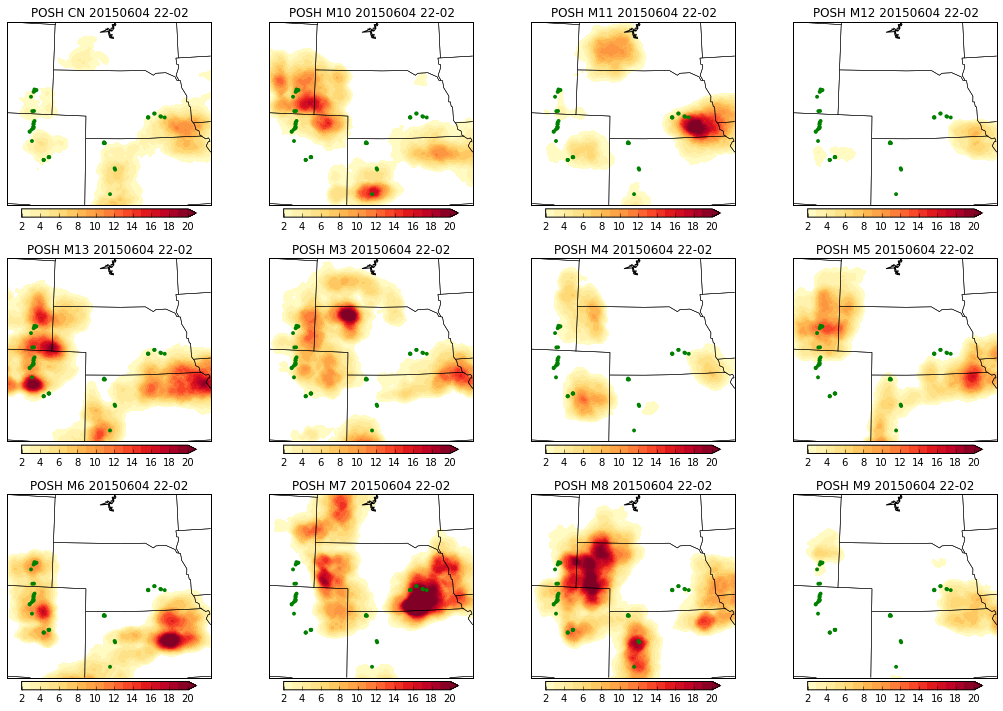

In [545]:
st = 11
et = 15
plt.figure(figsize=(18,12))
for p, mem in enumerate(sorted(data.keys())):
    plt.subplot(3,4,p+1)
    bmap2.drawstates()
    bmap2.drawcoastlines()
    bmap2.drawcountries()
    x, y = bmap2(ssef_grid['lon'], ssef_grid['lat'])
    hr_idxs = (hail_reports['Time'] >= 2200) | (hail_reports['Time'] <= 200)
    rx, ry = bmap2(hail_reports['Lon'][hr_idxs].values, hail_reports['Lat'][hr_idxs].values)
    cont = plt.contourf(x,y, 
                 gaussian_filter(data[mem][st:et].sum(axis=0),1) * 100, 
                 np.arange(2,21),
                 cmap="YlOrRd", extend="max")
    plt.title("POSH {3} {0} {1:02d}-{2:02d}".format(run_date,
                                                                                       (11 + st) % 24,
                                                                                       (11 + et) % 24,
                                                                                       mem.upper().split("_")[0][6:])
                                                                                        )

    plt.scatter(rx,ry,15,'green', edgecolors='')
    plt.colorbar(cont, orientation="horizontal",shrink=0.8, fraction=0.05, pad=0.02)
plt.savefig("/sharp/djgagne/track_sample_figures_spring2015/{0}/posh_postage_{0}_{1:02d}_{2:02d}.png".format(run_date,12+st,12+et), dpi=150, bbox_inches="tight")

In [516]:
copula_data = cPickle.load(open("/sharp/djgagne/track_copulas.pkl"))

Thompson
[0.17130307467057102, 14694.140706915348, 9589.86383949799]
[[ 1.          0.17342169 -0.18339226]
 [ 0.17342169  1.         -0.15075832]
 [-0.18339226 -0.15075832  1.        ]]
WDM6
[-0.18037135278514588, 4399.796797525601, 8100.443511026736]
[[ 1.          0.2172759  -0.10699951]
 [ 0.2172759   1.         -0.17308195]
 [-0.10699951 -0.17308195  1.        ]]
MY
[0.0375, -9679.87248521967, 16897.93344670973]
[[ 1.          0.14281745 -0.10278745]
 [ 0.14281745  1.         -0.07157908]
 [-0.10278745 -0.07157908  1.        ]]
Morrison
[-0.21206581352833637, -10879.197677264945, 5320.971513228667]
[[ 1.          0.25011116 -0.07398335]
 [ 0.25011116  1.         -0.10455004]
 [-0.07398335 -0.10455004  1.        ]]


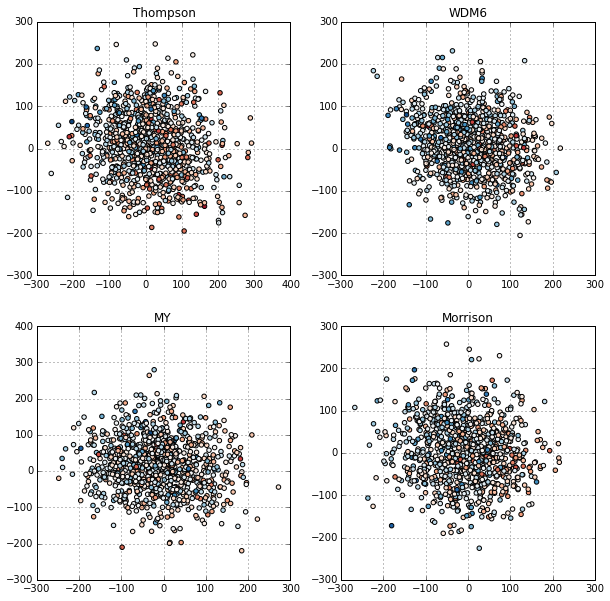

In [548]:
plt.figure(figsize=(10,10))
for g,group in enumerate(copula_data.keys()):
    plt.subplot(2,2,g+1)
    print group
    samples = multivariate_normal.rvs(copula_data[group]['mean'],
                                      copula_data[group]['cov'],
                                      1000)
    print copula_data[group]['mean'].tolist()
    print spearmanr(samples)[0]
    plt.scatter(samples[:,1]/1000,samples[:,2]/1000,20,samples[:,0],cmap='RdBu_r',vmin=-8,vmax=8)
    plt.grid()
    plt.title(group)
    

In [544]:
copula_data

{'MY': {'cov': array([[  3.97351097e+00,   2.18618861e+04,  -1.39840570e+04],
         [  2.18618861e+04,   7.23796158e+09,  -6.81456698e+08],
         [ -1.39840570e+04,  -6.81456698e+08,   5.41719950e+09]]),
  'mean': array([  3.75000000e-02,  -9.67987249e+03,   1.68979334e+04]),
  'model_names': ['start-time', 'translation-x', 'translation-y']},
 'Morrison': {'cov': array([[  4.36153913e+00,   4.24839135e+04,  -1.27148591e+04],
         [  4.24839135e+04,   6.79647124e+09,  -5.61778390e+08],
         [ -1.27148591e+04,  -5.61778390e+08,   5.20426432e+09]]),
  'mean': array([ -2.12065814e-01,  -1.08791977e+04,   5.32097151e+03]),
  'model_names': ['start-time', 'translation-x', 'translation-y']},
 'Thompson': {'cov': array([[  4.42662396e+00,   3.40095135e+04,  -2.27296881e+04],
         [  3.40095135e+04,   7.88734223e+09,  -8.20553898e+08],
         [ -2.27296881e+04,  -8.20553898e+08,   5.37976663e+09]]),
  'mean': array([  1.71303075e-01,   1.46941407e+04,   9.58986384e+03]),
  '

In [81]:
rf_model = cPickle.load(open("/sharp/djgagne/track_models_spring2015/MY_Gradient-Boosting_translation-x_track.pkl"))

<Container object of 111 artists>

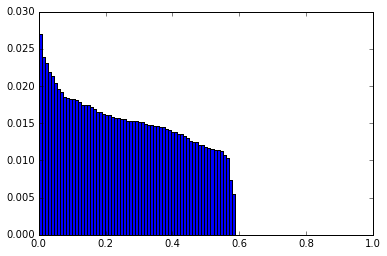

In [83]:
imp_steps = np.arange(rf_model.feature_importances_.size).astype(float)/ rf_model.feature_importances_.size
plt.bar(imp_steps,
        np.sort(rf_model.feature_importances_)[::-1],width=imp_steps[1])

In [6]:
input_columns = ["Forecast_Hour","Valid_Hour_UTC","Duration_Step","Duration_Total","Centroid_Lon","Centroid_Lat",
                 "cqgmax_mean","cqgmax_max","cqgmax_min","cqgmax_std","cqgmax_mean_dt","cqgmax_max_dt",
                 "cqgmax_std_dt","uh_max_mean","uh_max_max","uh_max_min","uh_max_std","uh_max_mean_dt",
                 "uh_max_max_dt","uh_max_std_dt","r10cmx_mean","r10cmx_max","r10cmx_min","r10cmx_std",
                 "r10cmx_mean_dt","r10cmx_max_dt","r10cmx_std_dt","wupmax_mean","wupmax_max","wupmax_min",
                 "wupmax_std","wupmax_mean_dt","wupmax_max_dt","wupmax_std_dt","wdnmax_mean","wdnmax_max",
                 "wdnmax_min","wdnmax_std","wdnmax_mean_dt","wdnmax_max_dt","wdnmax_std_dt","crefmx_mean",
                 "crefmx_max","crefmx_min","crefmx_std","crefmx_mean_dt","crefmx_max_dt","crefmx_std_dt",
                 "mlcape_mean","mlcape_max","mlcape_min","mlcape_std","mlcape_mean_dt","mlcape_max_dt",
                 "mlcape_std_dt","mlcins_mean","mlcins_max","mlcins_min","mlcins_std","mlcins_mean_dt",
                 "mlcins_max_dt","mlcins_std_dt","sblcl_mean","sblcl_max","sblcl_min","sblcl_std",
                 "sblcl_mean_dt","sblcl_max_dt","sblcl_std_dt","srh03_mean","srh03_max","srh03_min",
                 "srh03_std","srh03_mean_dt","srh03_max_dt","srh03_std_dt","shr06_mean","shr06_max",
                 "shr06_min","shr06_std","shr06_mean_dt","shr06_max_dt","shr06_std_dt","dewp2m_mean",
                 "dewp2m_max","dewp2m_min","dewp2m_std","dewp2m_mean_dt","dewp2m_max_dt","dewp2m_std_dt",
                 "temp2m_mean","temp2m_max","temp2m_min","temp2m_std","temp2m_mean_dt","temp2m_max_dt",
                 "temp2m_std_dt","sph850_mean","sph850_max","sph850_min","sph850_std","sph850_mean_dt",
                 "sph850_max_dt","sph850_std_dt","sph500_mean","sph500_max","sph500_min","sph500_std",
                 "sph500_mean_dt","sph500_max_dt","sph500_std_dt"]

In [82]:
for arank in rf_model.feature_importances_.argsort()[:50:-1]:
    print input_columns[arank], rf_model.feature_importances_[arank]

Centroid_Lon 0.0270117302951
Centroid_Lat 0.0238859390744
wupmax_min 0.0230627252232
shr06_mean 0.021820782603
r10cmx_mean 0.0214047347867
sph500_mean 0.0204024373982
wdnmax_max 0.0195908023298
sph500_min 0.019234083483
sph850_min 0.0184958167701
mlcins_std 0.0183877844229
crefmx_max 0.0182849982462
crefmx_min 0.0182773708978
shr06_std 0.0180540229099
sph500_max 0.0178882762296
sblcl_std 0.0174484673509
srh03_std 0.0174473882094
r10cmx_min 0.0174121511465
sblcl_min 0.0171498383508
dewp2m_max 0.0168452468825
sph500_std 0.0165675295562
cqgmax_std 0.0165018032813
sblcl_max 0.0161950672647
srh03_max 0.016089882407
temp2m_mean 0.0160414874446
sblcl_mean 0.0158638949118
cqgmax_min 0.0157615606783
mlcins_mean 0.0156319347282
mlcins_min 0.0155832875988
sph850_std 0.0155219425895
dewp2m_std 0.0153620980513
dewp2m_mean 0.0153525489332
wupmax_std 0.0152765260134
r10cmx_max 0.0152448718535
temp2m_std 0.01518185845
temp2m_min 0.0151667575837
mlcape_std 0.0148459315855
crefmx_std 0.0147802782509
tem

In [10]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [12]:
from processing.TrackModeler import TrackModeler

In [49]:
member_files={"train":"/sharp/djgagne/track_data_spring2014_csv/member_info_ssef_spring2014.csv",
              "forecast":"/sharp/djgagne/track_data_spring2014_csv/member_info_ssef_spring2014.csv"}
tm = TrackModeler("ssef",
                  "/sharp/djgagne/track_data_spring2014_csv/",
                  "/sharp/djgagne/track_data_spring2015_csv/20150525/",
                  member_files,
                  "Microphysics")
tm.load_data(mode="train")
tm.load_data(mode="forecast")

(<matplotlib.figure.Figure at 0x2b6730c85550>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x2b6735dd19d0>])

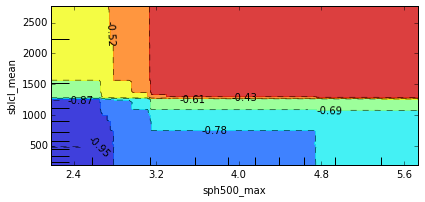

In [77]:
plot_partial_dependence(rf_model, tm.data['train']['combo'][input_columns].values,
                        [['sph500_max', 'sblcl_mean']], feature_names=input_columns)

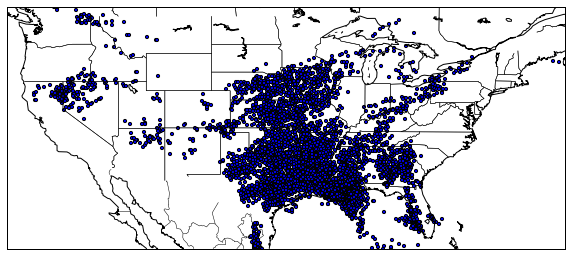

In [51]:
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawcoastlines()
plt.scatter(tm.data['forecast']['step']['Centroid_Lon'],tm.data['forecast']['step']['Centroid_Lat'],10,'b')

(array([   21.,   189.,   197.,   204.,   434.,  1088.,  1837.,  1717.,
           50.,     5.]),
 array([ 37.894   ,  43.112242,  48.330484,  53.548726,  58.766968,
         63.98521 ,  69.203452,  74.421694,  79.639936,  84.858178,
         90.07642 ]),
 <a list of 10 Patch objects>)

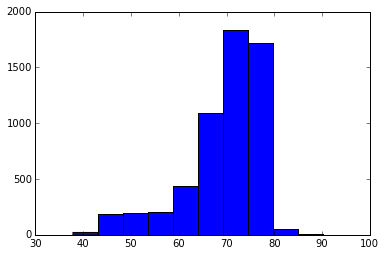

In [71]:
plt.hist(tm.data['forecast']['step']['dewp2m_max'],10)
